In [287]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import layers, Input, Model, optimizers
import pickle
import numpy as np
import keras.backend as K
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.initializers import glorot_uniform
import copy


In [289]:
with open('siamese_model.json', 'r') as json_file:
    json_saved_siamese_model= json_file.read()

In [290]:
def euclidean_distance_loss(y_true, y_pred):
    """
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [291]:
def identity_loss(y_true, y_pred):
    """
    Fake loss function for Keras.
    """
    return y_pred - 0 * y_true


In [307]:
siamese_model = tf.keras.models.model_from_json(json_saved_siamese_model)
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           4270016     input_1[0][0]                    
                                                                 input_2[0][0]                

In [293]:
siamese_model.load_weights('siamese_model.h5')

In [294]:
pickle_in = open("testdata.pickle", "rb")
test_data = pickle.load(pickle_in)
print(len(test_data))

2156


C:\Users\hanne\AppData\Local\Temp/ipykernel_11180/2221551553.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_data_array = np.array(test_data)


(3,)
(128, 128, 3)


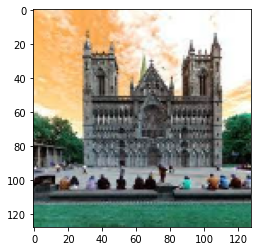

In [295]:
#print(test_data[0])
test_data_array = np.array(test_data)
#print(test_data_array.shape)
print(test_data_array[0].shape)
print(test_data_array[0][1].shape)
arr_ = np.squeeze(test_data_array[300][2]) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()

In [296]:
#for proof-checking. See if all tensors actually are finite elements. 
#Then see if every list of positive, equal and negative example actually contains 128,128,3. 
nan_in_tensors = 0
not_right_size_list = []
test_data_copy = copy.deepcopy(test_data)
for i in range(0, len(test_data)): 
    for j in range(0,3): 
        maybetrue = np.isnan(test_data[i][j]).any()
        if maybetrue: 
            nan_in_tensors += 1
        if np.shape(test_data[i][j]) != (128, 128, 3): 
            if np.shape(test_data[i][j]) == (128, 128, 4):
                test_data_copy[i][j] = np.delete(test_data_copy[i][j], 3, axis=-1)
            else: 
                not_right_size_list.append(i)


In [297]:
#print(not_right_size_list)

print(len(not_right_size_list))
print(len(test_data_copy))

for i in not_right_size_list[::-1]: 
    del(test_data_copy[i])
print(len(test_data_copy))
len_tdcopy = len(test_data_copy)

84
2156
2072


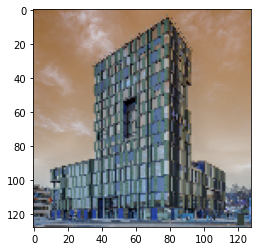

In [298]:

arr_ = np.squeeze(test_data_copy[14][2]) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()




In [299]:
no_batches = 50
len_tdcopy4 = len_tdcopy//no_batches +1

y_test = np.ones((len_tdcopy4,len_tdcopy4,len_tdcopy4))
y_test[len_tdcopy4-1,:,:] = np.zeros((len_tdcopy4,len_tdcopy4))


In [300]:
def fix_anchor_positive_negative_tensor_batch(batchsplit, name):
        split_arrays = np.array_split(name, batchsplit)      
        return split_arrays
siamese_test_batches = fix_anchor_positive_negative_tensor_batch(no_batches, test_data_copy)

In [303]:
def get_anc_pos_neg_in_batch(batch_list): 
    X_anchor = (batch_list[:,0,:,:,:])
    X_positive = (batch_list[:,1,:,:,:])
    X_negative = (batch_list[:,2,:,:,:])
    return X_anchor, X_positive, X_negative
X1_test, X2_test, X3_test = get_anc_pos_neg_in_batch(siamese_test_batches[0])
print(X3_test.shape)
print(y_test.shape)




(42, 128, 128, 3)
(42, 42, 42)


In [309]:
siamese_model.compile(loss=identity_loss, optimizer="Adam", metrics="accuracy")
#siamese_model.summary()


In [310]:
#val_loss = siamese_model.evaluate(x = [X1_test, X2_test, X3_test], y=y_test, verbose=0)[0]
#val_mae = siamese_model.evaluate(x_test, y_test, verbose=0)[1]
#print('validation loss (MSE):', val_loss, '\nvalidation MAE:', "val_mae")

loss, acc = siamese_model.evaluate([X1_test, X2_test, X3_test], y_test, verbose=2)
print("accuracy: ", acc)

StagingError: in user code:

    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\training.py:1330 test_function  *
        return step_function(self, iterator)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\training.py:1313 run_step  **
        outputs = model.test_step(data)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\training.py:1271 test_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\compile_utils.py:358 build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\util\nest.py:1376 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\util\nest.py:1474 map_structure_with_tuple_paths_up_to
        results = [
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\util\nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\tensorflow\python\util\nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\hanne\minic\miniconda3\envs\ttk4250\lib\site-packages\keras\engine\compile_utils.py:506 _get_metric_object
        y_p_last_dim = y_p.shape.as_list()[-1]

    IndexError: list index out of range
